## Calculation

First, lets define some parameters for following

In [1]:
import evaluate
import pandas as pd

eval_df = pd.read_parquet("./data/66-test-dataset-with-adrd.parquet")

In [26]:
metric_names = ["meteor"]
column_names = ["adrd_dpv3", "gpt-o3", "adrd_qwen3_14b"]

In [31]:
import math
import warnings

from tools.calculators import EvalCalculatorFactory

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# calculator = evaluate.load("meteor")

# Construct a dictionary to store the results
res = {}
for column_name in column_names:
    res[column_name] = []


# Initialize the calculator
calculator = EvalCalculatorFactory()

for idx, row in eval_df.iterrows():
    ref: str = row["Answer"]
    
    calculator.references = ref
    
    for column_name in column_names:
        pred: str = row[column_name]
        
        calculator.predictions = pred
        
        for metric_name in metric_names:
            res[column_name].append(calculator.call(metric_name))
    
    # print(resp)
    
print(res)

for column_name in column_names:
    print(f"{column_name}: {math.fsum(res[column_name]) / len(res[column_name])}")

# print(f"{metric_name}: {math.fsum(res) / len(res)}")


[nltk_data] Downloading package wordnet to /home/yuz211/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yuz211/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yuz211/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


ValueError: Mismatch in the number of predictions (1465) and references (2243)

Visualization

In [1]:
plot_data = {
    "preceed": {"bleu": 0.075, "bert": 0.637, "rouge": 0.411},
    "CaLM-ADRD-DPV3": {"bleu": 0.1168, "bert": 0.6457, "rouge": 0.3434},
}

Draw the plot

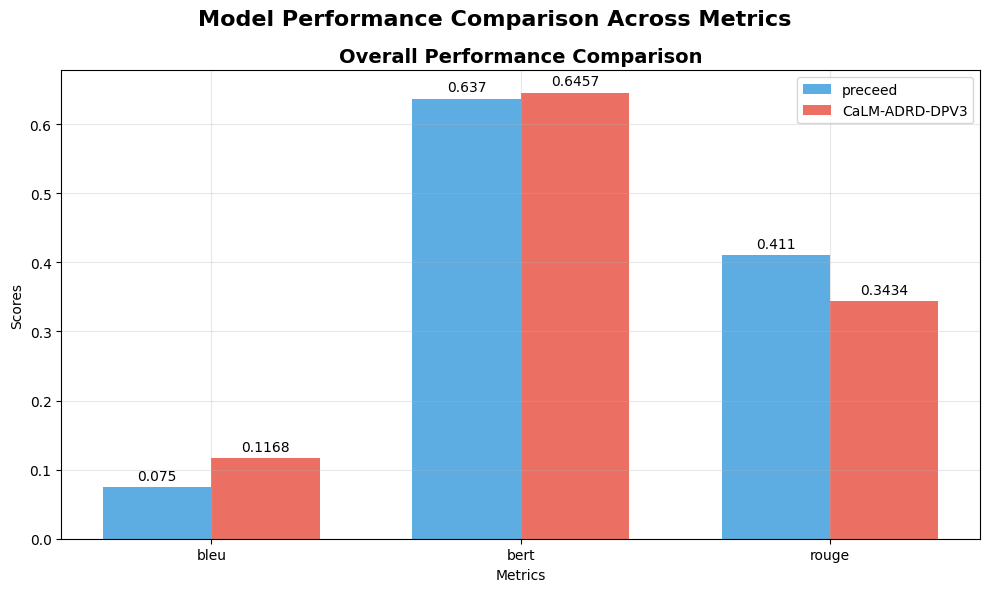

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
models = list(plot_data.keys())
metrics = list(plot_data[models[0]].keys())

# Create figure with single subplot
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Model Performance Comparison Across Metrics", fontsize=16, fontweight="bold")

# Color scheme
model_colors = ["#3498db", "#e74c3c"]

# Bar chart comparing all metrics
_ = ax.set_title("Overall Performance Comparison", fontsize=14, fontweight="bold")
x = np.arange(len(metrics))
width = 0.35

preceed_scores = [plot_data["preceed"][metric] for metric in metrics]
calm_scores = [plot_data["CaLM-ADRD-DPV3"][metric] for metric in metrics]

bars1 = ax.bar(x - width/2, preceed_scores, width, label="preceed", color=model_colors[0], alpha=0.8)
bars2 = ax.bar(x + width/2, calm_scores, width, label="CaLM-ADRD-DPV3", color=model_colors[1], alpha=0.8)

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()


## Calculation without reference

In [ ]:
example_text = """
When looking for activities for someone with dementia, it is important to consider their interests and hobbies [1]. Taking inventory of their past and current interests can help you come up with ideas. Some examples of activities that they might enjoy include gardening, crafting, playing or watching sports, cooking, reading about historical events, fishing, photography, or listening to or playing certain types of music [1].

It is also important to adapt these activities to fit their abilities as their condition progresses [1]. Providing additional assistance and supervision may be necessary, but adapting the activities themselves is also important. For example, if they enjoyed reading, you can take turns reading a favorite book aloud to them [2]. This can help exercise their mind and give them the pleasure of reading a beloved book.

Listening to music is another activity that can be enjoyable for someone with dementia [2]. Research has shown that music can help them remember events, people, and places from their past. It can also be a way to get them moving through dance or song. You can choose music that matches their needs, such as sing-along activities, upbeat motivating tunes, or relaxing sounds [2].

In addition, there are activity boards available for purchase that are specifically designed for people with dementia [3]. These boards have various tasks on them, such as buttons, zippers, and Velcro, and include things with different textures and sounds. They are aimed at keeping a person's hands busy and providing mental stimulation [3].

Overall, when selecting activities for someone with dementia, it is important to consider their interests, adapt the activities to their abilities, and provide the necessary support and supervision. Activities such as gardening, crafting, reading, listening to music, and using activity boards can be enjoyable and engaging for individuals with dementia.

References:
[1] https://www.agingcare.com/articles/my-elderly-parent-has-dementia-what-activities-can-we-do-together-137087.htm
[2] https://www.agingcare.com/articles/activities-for-alzheimers-148840.htm
[3] https://www.agingcare.com/articles/hobbies-and-activities-for-seniors-tips-from-family-caregivers-205881.htm
"""


def truncate_text(text: str) -> str:
    return text.split("References:")[0]


print(truncate_text(example_text))

In [ ]:
# Redo calculation use answers without references.

import math
import warnings
from time import sleep

from tools.calculators import EvalCalculatorFactory

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

score_list = {
    "bleu": [],
    "rouge": [],
    "char_f": [],
    "bert": [],
}

for idx, row in eval_df.iterrows():
    ref = truncate_text(row["Answer"])
    pred = truncate_text(row["adrd_dpv3"])
    
    calculator = EvalCalculatorFactory(predictions=[pred], references=[ref])
    score_list["bleu"].append(calculator.bleu()["bleu"])
    score_list["bert"].append(calculator.bert()["f1"][0])
    score_list["rouge"].append(calculator.rouge()["rougeLsum"])
    score_list["char_f"].append(calculator.char_f()["score"])
    
    sleep(1)

# print(score_list)

print(f"BLEU: {math.fsum(score_list['bleu']) / len(score_list['bleu'])}")
print(f"BERT: {math.fsum(score_list['bert']) / len(score_list['bert'])}")
print(f"ROUGE: {math.fsum(score_list['rouge']) / len(score_list['rouge'])}")
print(f"CHAR_F: {math.fsum(score_list['char_f']) / len(score_list['char_f'])}")
